In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [2]:
epic_dir = './g-research-crypto-forecasting/'

In [3]:
os.listdir(epic_dir)

['asset_details.csv',
 'example_sample_submission.csv',
 'example_test.csv',
 'gresearch_crypto',
 'supplemental_train.csv',
 'train.csv']

## Data Preparation

## 1 - Raw to clean data
train.csv will be read in this step. It includes these variables as mentioned in the challenge:

 - `timestamp` - A timestamp for the minute covered by the row. 
 - `Asset_ID` - An ID code for the cryptoasset. 
 - `Count` - The number of trades that took place this minute.
 - `Open` - The USD price at the beginning of the minute. 
 - `High` - The highest USD price during the minute. 
 - `Low` - The lowest USD price during the minute. 
 - `Close` - The USD price at the end of the minute. 
 - `Volume` - The number of cryptoasset units traded during the minute. 
 - `VWAP` - The volume weighted average price for the minute. 
 - `Target` - 15 minute residualized returns. 
 
As timestamp column is provided, from that the following will be extracted :

- `hour` is the hour of the day 
- `weekday` is the weekday of the week

We have Categorical variables (`Asset_ID`, `hour`, and `weekday`) and Numeric variables (`Count`, `Open`, `High`, `Low`, `Close`, `Volume`, and `VWAP`) . To process them together for model fitting, categorical variables will be one hot encoded and numeric variables will be scaled from 0 to 1 for their respective Asset_ID.

In [4]:
#Reading the csv data files 
df_train = pd.read_csv('./g-research-crypto-forecasting/train.csv')
df_asset_details = pd.read_csv('./g-research-crypto-forecasting/asset_details.csv')
df_test = pd.read_csv('./g-research-crypto-forecasting/example_test.csv')

In [5]:
df_train.shape

(24236806, 10)

The training set has 24 million records and 10 columns.

The runtime will be very high of the data set. We subset the data to 2020 November to reduce the run time of the model.

In [6]:
# Converting timestamp to date time
df_train['timestamp'] = df_train.timestamp.astype('datetime64[s]')
df_train = df_train[df_train.timestamp.dt.year==2020]
df_train = df_train[df_train.timestamp.dt.month==11]
df_train.shape

(598769, 10)

Now the reduced training set has 598,769 records.

In [7]:
df_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
17714600,2020-11-01 00:01:00,3,61.0,0.092705,0.092764,0.092566,0.092626,1.658528e+05,0.092651,0.001047
17714601,2020-11-01 00:01:00,2,163.0,261.896000,262.160000,261.590000,261.904000,1.985741e+02,261.854820,-0.002429
17714602,2020-11-01 00:01:00,0,150.0,28.347800,28.362300,28.303400,28.342000,5.011629e+03,28.328415,-0.005357
17714603,2020-11-01 00:01:00,1,2445.0,13734.228920,13754.300000,13720.000000,13741.110730,2.135172e+02,13737.261551,0.000794
17714604,2020-11-01 00:01:00,4,10.0,0.002560,0.002562,0.002558,0.002561,1.174202e+05,0.002561,0.004920
...,...,...,...,...,...,...,...,...,...,...
18313364,2020-11-30 23:59:00,9,281.0,87.689714,87.880000,87.590000,87.671286,3.960266e+03,87.733833,-0.000098
18313365,2020-11-30 23:59:00,10,49.0,568.198400,569.230000,567.805800,568.227433,2.044260e+01,568.515584,-0.006150
18313366,2020-11-30 23:59:00,13,149.0,0.032355,0.032400,0.032340,0.032361,3.776827e+06,0.032367,0.000044
18313367,2020-11-30 23:59:00,12,365.0,0.202874,0.203569,0.202651,0.202946,9.302105e+05,0.203051,-0.006227


In [8]:
df_train.loc[:,['Asset_ID', 'timestamp']]

,Asset_ID,timestamp
17714600,3,2020-11-01 00:01:00
17714601,2,2020-11-01 00:01:00
17714602,0,2020-11-01 00:01:00
17714603,1,2020-11-01 00:01:00
17714604,4,2020-11-01 00:01:00
...,...,...
18313364,9,2020-11-30 23:59:00
18313365,10,2020-11-30 23:59:00
18313366,13,2020-11-30 23:59:00
18313367,12,2020-11-30 23:59:00


## 2 - Missing Values Update

Checking missing values

In [9]:
df_train.isna().sum()

timestamp       0
Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target       8814
dtype: int64

There are 8,814 of records of target variables missing as illustrated above.

To see for infinity or missing values in particular :

In [10]:
df_train.isin([np.nan, np.inf, -np.inf]).sum()

timestamp       0
Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target       8814
dtype: int64

There is 0 record with infinity or missing values for `Low`, `Close`, `Colume` and `VWAP` column. THe following code will drop the missing values and infinity values.

In case of dropping missing values, following approach will be used:

In [11]:
df_train.dropna(inplace=True)
df_train = df_train[np.isfinite(df_train).all(1)]

In [12]:
df_train.isin([np.nan, np.inf, -np.inf]).sum()

timestamp    0
Asset_ID     0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         0
Target       0
dtype: int64

In [13]:
df_train.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,589955.000000,589955.000000,589955.000000,589955.000000,589955.000000,589955.000000,5.899550e+05,589955.000000,589955.000000
mean,6.473456,285.892887,1320.409986,1322.450504,1318.366282,1320.418393,3.544014e+05,1320.401154,0.000027
std,4.068315,628.253640,4301.293082,4307.891268,4294.558528,4301.324037,1.416194e+06,4301.260318,0.004511
min,0.000000,1.000000,0.002451,0.002453,0.002450,0.002452,6.000000e-05,0.002452,-0.126551
25%,3.000000,28.000000,0.128017,0.128417,0.127590,0.128001,1.872239e+02,0.127994,-0.001631
50%,6.000000,80.000000,27.651600,27.671300,27.629000,27.651700,2.062042e+03,27.651692,-0.000049
75%,10.000000,262.000000,262.734500,263.210000,262.340000,262.732917,6.408410e+04,262.729967,0.001547
max,13.000000,38146.000000,19842.913750,19873.230000,19762.400000,19840.008750,1.539141e+08,19826.506346,0.089697


With describe, statistical description of dataframe was returned with the respective passed percentiles.

## Feature Engineering
Time stamp is divided into date time type variable to give `hour` and `weekday` features column.

In [14]:
# Create hour feature column
df_train['hour'] = df_train.timestamp.dt.hour

# Create weekday feature column
df_train['weekday'] = df_train.timestamp.dt.weekday

In [15]:
df_train.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,hour,weekday
count,589955.000000,589955.000000,589955.000000,589955.000000,589955.000000,589955.000000,5.899550e+05,589955.000000,589955.000000,589955.000000,589955.000000
mean,6.473456,285.892887,1320.409986,1322.450504,1318.366282,1320.418393,3.544014e+05,1320.401154,0.000027,11.507132,2.997679
std,4.068315,628.253640,4301.293082,4307.891268,4294.558528,4301.324037,1.416194e+06,4301.260318,0.004511,6.910187,2.079234
min,0.000000,1.000000,0.002451,0.002453,0.002450,0.002452,6.000000e-05,0.002452,-0.126551,0.000000,0.000000
25%,3.000000,28.000000,0.128017,0.128417,0.127590,0.128001,1.872239e+02,0.127994,-0.001631,6.000000,1.000000
50%,6.000000,80.000000,27.651600,27.671300,27.629000,27.651700,2.062042e+03,27.651692,-0.000049,12.000000,3.000000
75%,10.000000,262.000000,262.734500,263.210000,262.340000,262.732917,6.408410e+04,262.729967,0.001547,17.000000,5.000000
max,13.000000,38146.000000,19842.913750,19873.230000,19762.400000,19840.008750,1.539141e+08,19826.506346,0.089697,23.000000,6.000000


In [16]:
df_train.loc[:,['Asset_ID', 'timestamp']]

,Asset_ID,timestamp
17714600,3,2020-11-01 00:01:00
17714601,2,2020-11-01 00:01:00
17714602,0,2020-11-01 00:01:00
17714603,1,2020-11-01 00:01:00
17714604,4,2020-11-01 00:01:00
...,...,...
18313364,9,2020-11-30 23:59:00
18313365,10,2020-11-30 23:59:00
18313366,13,2020-11-30 23:59:00
18313367,12,2020-11-30 23:59:00


In [17]:
df_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,hour,weekday
17714600,2020-11-01 00:01:00,3,61.0,0.092705,0.092764,0.092566,0.092626,1.658528e+05,0.092651,0.001047,0,6
17714601,2020-11-01 00:01:00,2,163.0,261.896000,262.160000,261.590000,261.904000,1.985741e+02,261.854820,-0.002429,0,6
17714602,2020-11-01 00:01:00,0,150.0,28.347800,28.362300,28.303400,28.342000,5.011629e+03,28.328415,-0.005357,0,6
17714603,2020-11-01 00:01:00,1,2445.0,13734.228920,13754.300000,13720.000000,13741.110730,2.135172e+02,13737.261551,0.000794,0,6
17714604,2020-11-01 00:01:00,4,10.0,0.002560,0.002562,0.002558,0.002561,1.174202e+05,0.002561,0.004920,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
18313364,2020-11-30 23:59:00,9,281.0,87.689714,87.880000,87.590000,87.671286,3.960266e+03,87.733833,-0.000098,23,0
18313365,2020-11-30 23:59:00,10,49.0,568.198400,569.230000,567.805800,568.227433,2.044260e+01,568.515584,-0.006150,23,0
18313366,2020-11-30 23:59:00,13,149.0,0.032355,0.032400,0.032340,0.032361,3.776827e+06,0.032367,0.000044,23,0
18313367,2020-11-30 23:59:00,12,365.0,0.202874,0.203569,0.202651,0.202946,9.302105e+05,0.203051,-0.006227,23,0


In [18]:
df_train.loc[:,['Asset_ID', 'timestamp','hour','weekday']]

,Asset_ID,timestamp,hour,weekday
17714600,3,2020-11-01 00:01:00,0,6
17714601,2,2020-11-01 00:01:00,0,6
17714602,0,2020-11-01 00:01:00,0,6
17714603,1,2020-11-01 00:01:00,0,6
17714604,4,2020-11-01 00:01:00,0,6
...,...,...,...,...
18313364,9,2020-11-30 23:59:00,23,0
18313365,10,2020-11-30 23:59:00,23,0
18313366,13,2020-11-30 23:59:00,23,0
18313367,12,2020-11-30 23:59:00,23,0


In [19]:
df_train.loc[:,['Asset_ID','hour','weekday']]

,Asset_ID,hour,weekday
17714600,3,0,6
17714601,2,0,6
17714602,0,0,6
17714603,1,0,6
17714604,4,0,6
...,...,...,...
18313364,9,23,0
18313365,10,23,0
18313366,13,23,0
18313367,12,23,0


## 1- One Hot Encode Categorical Variables
This section will convert variables `Asset_ID`, `hour` and `weekday` to categorical variables and create one hot encoder for categorical variables.

A one hot encoding allows the representation of categorical data to be more expressive.

Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. This is required for both input and output variables that are categorical.

https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/#:~:text=A%20one%20hot%20encoding%20allows,output%20variables%20that%20are%20categorical.



One hot encoding is a highly essential part of the feature engineering process in training for learning techniques. For example, we had our variables like colors and the labels were “red,” “green,” and “blue,” we could encode each of these labels as a three-element binary vector as Red: [1, 0, 0], Green: [0, 1, 0], Blue: [0, 0, 1]. The Categorical data while processing, must be converted to a numerical form. One-hot encoding is generally applied to the integer representation of the data. Here the integer encoded variable is removed and a new binary variable is added for each unique integer value. During the process, it takes a column that has categorical data, which has been label encoded and then splits the following column into multiple columns. The numbers are replaced by 1s and 0s randomly, depending on which column has what value.

https://analyticsindiamag.com/when-to-use-one-hot-encoding-in-deep-learning/

In [20]:
# Convert Asset_ID, hour and weekday to categorical variable
df_train['Asset_ID'] = df_train.Asset_ID.astype('category')
df_train['hour'] = df_train.hour.astype('category')
df_train['weekday'] = df_train.weekday.astype('category')

In [21]:
df_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,hour,weekday
17714600,2020-11-01 00:01:00,3,61.0,0.092705,0.092764,0.092566,0.092626,1.658528e+05,0.092651,0.001047,0,6
17714601,2020-11-01 00:01:00,2,163.0,261.896000,262.160000,261.590000,261.904000,1.985741e+02,261.854820,-0.002429,0,6
17714602,2020-11-01 00:01:00,0,150.0,28.347800,28.362300,28.303400,28.342000,5.011629e+03,28.328415,-0.005357,0,6
17714603,2020-11-01 00:01:00,1,2445.0,13734.228920,13754.300000,13720.000000,13741.110730,2.135172e+02,13737.261551,0.000794,0,6
17714604,2020-11-01 00:01:00,4,10.0,0.002560,0.002562,0.002558,0.002561,1.174202e+05,0.002561,0.004920,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
18313364,2020-11-30 23:59:00,9,281.0,87.689714,87.880000,87.590000,87.671286,3.960266e+03,87.733833,-0.000098,23,0
18313365,2020-11-30 23:59:00,10,49.0,568.198400,569.230000,567.805800,568.227433,2.044260e+01,568.515584,-0.006150,23,0
18313366,2020-11-30 23:59:00,13,149.0,0.032355,0.032400,0.032340,0.032361,3.776827e+06,0.032367,0.000044,23,0
18313367,2020-11-30 23:59:00,12,365.0,0.202874,0.203569,0.202651,0.202946,9.302105e+05,0.203051,-0.006227,23,0


In [22]:
# Set up Encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# fit onehotcoder
encoder.fit(df_train[['Asset_ID','hour','weekday']])

OneHotEncoder(handle_unknown='ignore', sparse=False)

sparse = false. Description : Some algorithms are not written to operate on sparse matrices, and so forcing your OneHotEncoder to produce dense output is desirable despite the additional memory use. (See this question for a recent example.) It's also easier to view the output of a dense matrix.

In [23]:
# get new encoded cols names
encoded_cols = list(encoder.get_feature_names(['Asset_ID','hour','weekday']))

# replace categorical variables with one hot encoder
df_train[encoded_cols] = encoder.transform(df_train[['Asset_ID','hour','weekday']])

In [24]:
encoded_cols

['Asset_ID_0',
 'Asset_ID_1',
 'Asset_ID_2',
 'Asset_ID_3',
 'Asset_ID_4',
 'Asset_ID_5',
 'Asset_ID_6',
 'Asset_ID_7',
 'Asset_ID_8',
 'Asset_ID_9',
 'Asset_ID_10',
 'Asset_ID_11',
 'Asset_ID_12',
 'Asset_ID_13',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [25]:
df_train[encoded_cols]

,Asset_ID_0,Asset_ID_1,Asset_ID_2,Asset_ID_3,Asset_ID_4,Asset_ID_5,Asset_ID_6,Asset_ID_7,Asset_ID_8,Asset_ID_9,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17714600,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714601,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714602,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714603,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714604,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18313364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17714600,2020-11-01 00:01:00,3,61.0,0.092705,0.092764,0.092566,0.092626,165852.794349,0.092651,0.001047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714601,2020-11-01 00:01:00,2,163.0,261.896000,262.160000,261.590000,261.904000,198.574079,261.854820,-0.002429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714602,2020-11-01 00:01:00,0,150.0,28.347800,28.362300,28.303400,28.342000,5011.629000,28.328415,-0.005357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714603,2020-11-01 00:01:00,1,2445.0,13734.228920,13754.300000,13720.000000,13741.110730,213.517157,13737.261551,0.000794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714604,2020-11-01 00:01:00,4,10.0,0.002560,0.002562,0.002558,0.002561,117420.170000,0.002561,0.004920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
df_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17714600,2020-11-01 00:01:00,3,61.0,0.092705,0.092764,0.092566,0.092626,1.658528e+05,0.092651,0.001047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714601,2020-11-01 00:01:00,2,163.0,261.896000,262.160000,261.590000,261.904000,1.985741e+02,261.854820,-0.002429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714602,2020-11-01 00:01:00,0,150.0,28.347800,28.362300,28.303400,28.342000,5.011629e+03,28.328415,-0.005357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714603,2020-11-01 00:01:00,1,2445.0,13734.228920,13754.300000,13720.000000,13741.110730,2.135172e+02,13737.261551,0.000794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714604,2020-11-01 00:01:00,4,10.0,0.002560,0.002562,0.002558,0.002561,1.174202e+05,0.002561,0.004920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18313364,2020-11-30 23:59:00,9,281.0,87.689714,87.880000,87.590000,87.671286,3.960266e+03,87.733833,-0.000098,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313365,2020-11-30 23:59:00,10,49.0,568.198400,569.230000,567.805800,568.227433,2.044260e+01,568.515584,-0.006150,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313366,2020-11-30 23:59:00,13,149.0,0.032355,0.032400,0.032340,0.032361,3.776827e+06,0.032367,0.000044,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313367,2020-11-30 23:59:00,12,365.0,0.202874,0.203569,0.202651,0.202946,9.302105e+05,0.203051,-0.006227,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2- Scale Numeric Variables
This section will scale numeric variables `Count`, `Open`, `High`, `Low`, `Close`, `Volume`, and `VWAP` to range from 0 to 1.

In [28]:
df_train.loc[:,['Count','Open','High', 'Low','Close','Volume','VWAP','Target']]

,Count,Open,High,Low,Close,Volume,VWAP,Target
17714600,61.0,0.092705,0.092764,0.092566,0.092626,1.658528e+05,0.092651,0.001047
17714601,163.0,261.896000,262.160000,261.590000,261.904000,1.985741e+02,261.854820,-0.002429
17714602,150.0,28.347800,28.362300,28.303400,28.342000,5.011629e+03,28.328415,-0.005357
17714603,2445.0,13734.228920,13754.300000,13720.000000,13741.110730,2.135172e+02,13737.261551,0.000794
17714604,10.0,0.002560,0.002562,0.002558,0.002561,1.174202e+05,0.002561,0.004920
...,...,...,...,...,...,...,...,...
18313364,281.0,87.689714,87.880000,87.590000,87.671286,3.960266e+03,87.733833,-0.000098
18313365,49.0,568.198400,569.230000,567.805800,568.227433,2.044260e+01,568.515584,-0.006150
18313366,149.0,0.032355,0.032400,0.032340,0.032361,3.776827e+06,0.032367,0.000044
18313367,365.0,0.202874,0.203569,0.202651,0.202946,9.302105e+05,0.203051,-0.006227


In [29]:
scaler = MinMaxScaler()

num_cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']

scaler.fit(df_train[num_cols])
df_train[num_cols] = scaler.transform(df_train[num_cols])

In [30]:
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17714600,2020-11-01 00:01:00,3,0.001573,4.548390e-06,4.544355e-06,4.559973e-06,4.545024e-06,0.001078,4.549415e-06,0.001047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714601,2020-11-01 00:01:00,2,0.004247,1.319834e-02,1.319149e-02,1.323663e-02,1.320068e-02,0.000001,1.320719e-02,-0.002429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714602,2020-11-01 00:01:00,0,0.003906,1.428487e-03,1.427038e-03,1.432061e-03,1.428404e-03,0.000033,1.428692e-03,-0.005357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714603,2020-11-01 00:01:00,1,0.064071,6.921478e-01,6.921018e-01,6.942476e-01,6.925960e-01,0.000001,6.928735e-01,0.000794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714604,2020-11-01 00:01:00,4,0.000236,5.478027e-09,5.499862e-09,5.464924e-09,5.478829e-09,0.000763,5.475302e-09,0.004920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
df_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17714600,2020-11-01 00:01:00,3,0.001573,4.548390e-06,4.544355e-06,4.559973e-06,4.545024e-06,1.077568e-03,4.549415e-06,0.001047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714601,2020-11-01 00:01:00,2,0.004247,1.319834e-02,1.319149e-02,1.323663e-02,1.320068e-02,1.290162e-06,1.320719e-02,-0.002429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714602,2020-11-01 00:01:00,0,0.003906,1.428487e-03,1.427038e-03,1.432061e-03,1.428404e-03,3.256122e-05,1.428692e-03,-0.005357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714603,2020-11-01 00:01:00,1,0.064071,6.921478e-01,6.921018e-01,6.942476e-01,6.925960e-01,1.387249e-06,6.928735e-01,0.000794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714604,2020-11-01 00:01:00,4,0.000236,5.478027e-09,5.499862e-09,5.464924e-09,5.478829e-09,7.628944e-04,5.475302e-09,0.004920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18313364,2020-11-30 23:59:00,9,0.007340,4.419072e-03,4.421906e-03,4.432031e-03,4.418791e-03,2.573038e-05,4.424955e-03,-0.000098,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313365,2020-11-30 23:59:00,10,0.001258,2.863471e-02,2.864293e-02,2.873150e-02,2.864036e-02,1.328179e-07,2.867440e-02,-0.006150,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313366,2020-11-30 23:59:00,13,0.003880,1.506997e-06,1.506902e-06,1.512468e-06,1.507470e-06,2.453854e-02,1.508825e-06,0.000044,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18313367,2020-11-30 23:59:00,12,0.009543,1.010048e-05,1.011995e-05,1.013040e-05,1.010554e-05,6.043701e-03,1.011770e-05,-0.006227,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_train.loc[:,['Count','Open','High', 'Low','Close','Volume','VWAP','Target']]

,Count,Open,High,Low,Close,Volume,VWAP,Target
17714600,0.001573,4.548390e-06,4.544355e-06,4.559973e-06,4.545024e-06,1.077568e-03,4.549415e-06,0.001047
17714601,0.004247,1.319834e-02,1.319149e-02,1.323663e-02,1.320068e-02,1.290162e-06,1.320719e-02,-0.002429
17714602,0.003906,1.428487e-03,1.427038e-03,1.432061e-03,1.428404e-03,3.256122e-05,1.428692e-03,-0.005357
17714603,0.064071,6.921478e-01,6.921018e-01,6.942476e-01,6.925960e-01,1.387249e-06,6.928735e-01,0.000794
17714604,0.000236,5.478027e-09,5.499862e-09,5.464924e-09,5.478829e-09,7.628944e-04,5.475302e-09,0.004920
...,...,...,...,...,...,...,...,...
18313364,0.007340,4.419072e-03,4.421906e-03,4.432031e-03,4.418791e-03,2.573038e-05,4.424955e-03,-0.000098
18313365,0.001258,2.863471e-02,2.864293e-02,2.873150e-02,2.864036e-02,1.328179e-07,2.867440e-02,-0.006150
18313366,0.003880,1.506997e-06,1.506902e-06,1.512468e-06,1.507470e-06,2.453854e-02,1.508825e-06,0.000044
18313367,0.009543,1.010048e-05,1.011995e-05,1.013040e-05,1.010554e-05,6.043701e-03,1.011770e-05,-0.006227


## 3- Exploratory Analysis
This section explores the association between each variables and the target variable.

#### Time Series Plots
The following code get the time range for each of the `Asset_ID`.

In [33]:
df_train.groupby(["Asset_ID"]).agg({'timestamp': [np.min,np.max]})

timestamp                    
                        amin                amax
Asset_ID                                        
0        2020-11-01 00:01:00 2020-11-30 23:59:00
1        2020-11-01 00:01:00 2020-11-30 23:59:00
2        2020-11-01 00:01:00 2020-11-30 23:59:00
3        2020-11-01 00:01:00 2020-11-30 23:59:00
4        2020-11-01 00:01:00 2020-11-30 23:59:00
5        2020-11-01 00:01:00 2020-11-30 23:59:00
6        2020-11-01 00:01:00 2020-11-30 23:59:00
7        2020-11-01 00:01:00 2020-11-30 23:59:00
8        2020-11-01 00:01:00 2020-11-30 23:59:00
9        2020-11-01 00:01:00 2020-11-30 23:59:00
10       2020-11-01 00:01:00 2020-11-30 23:59:00
11       2020-11-01 00:01:00 2020-11-30 23:59:00
12       2020-11-01 00:01:00 2020-11-30 23:59:00
13       2020-11-01 00:01:00 2020-11-30 23:59:00

The date range is slightly different for each of the asset.

<AxesSubplot:xlabel='timestamp', ylabel='Target'>

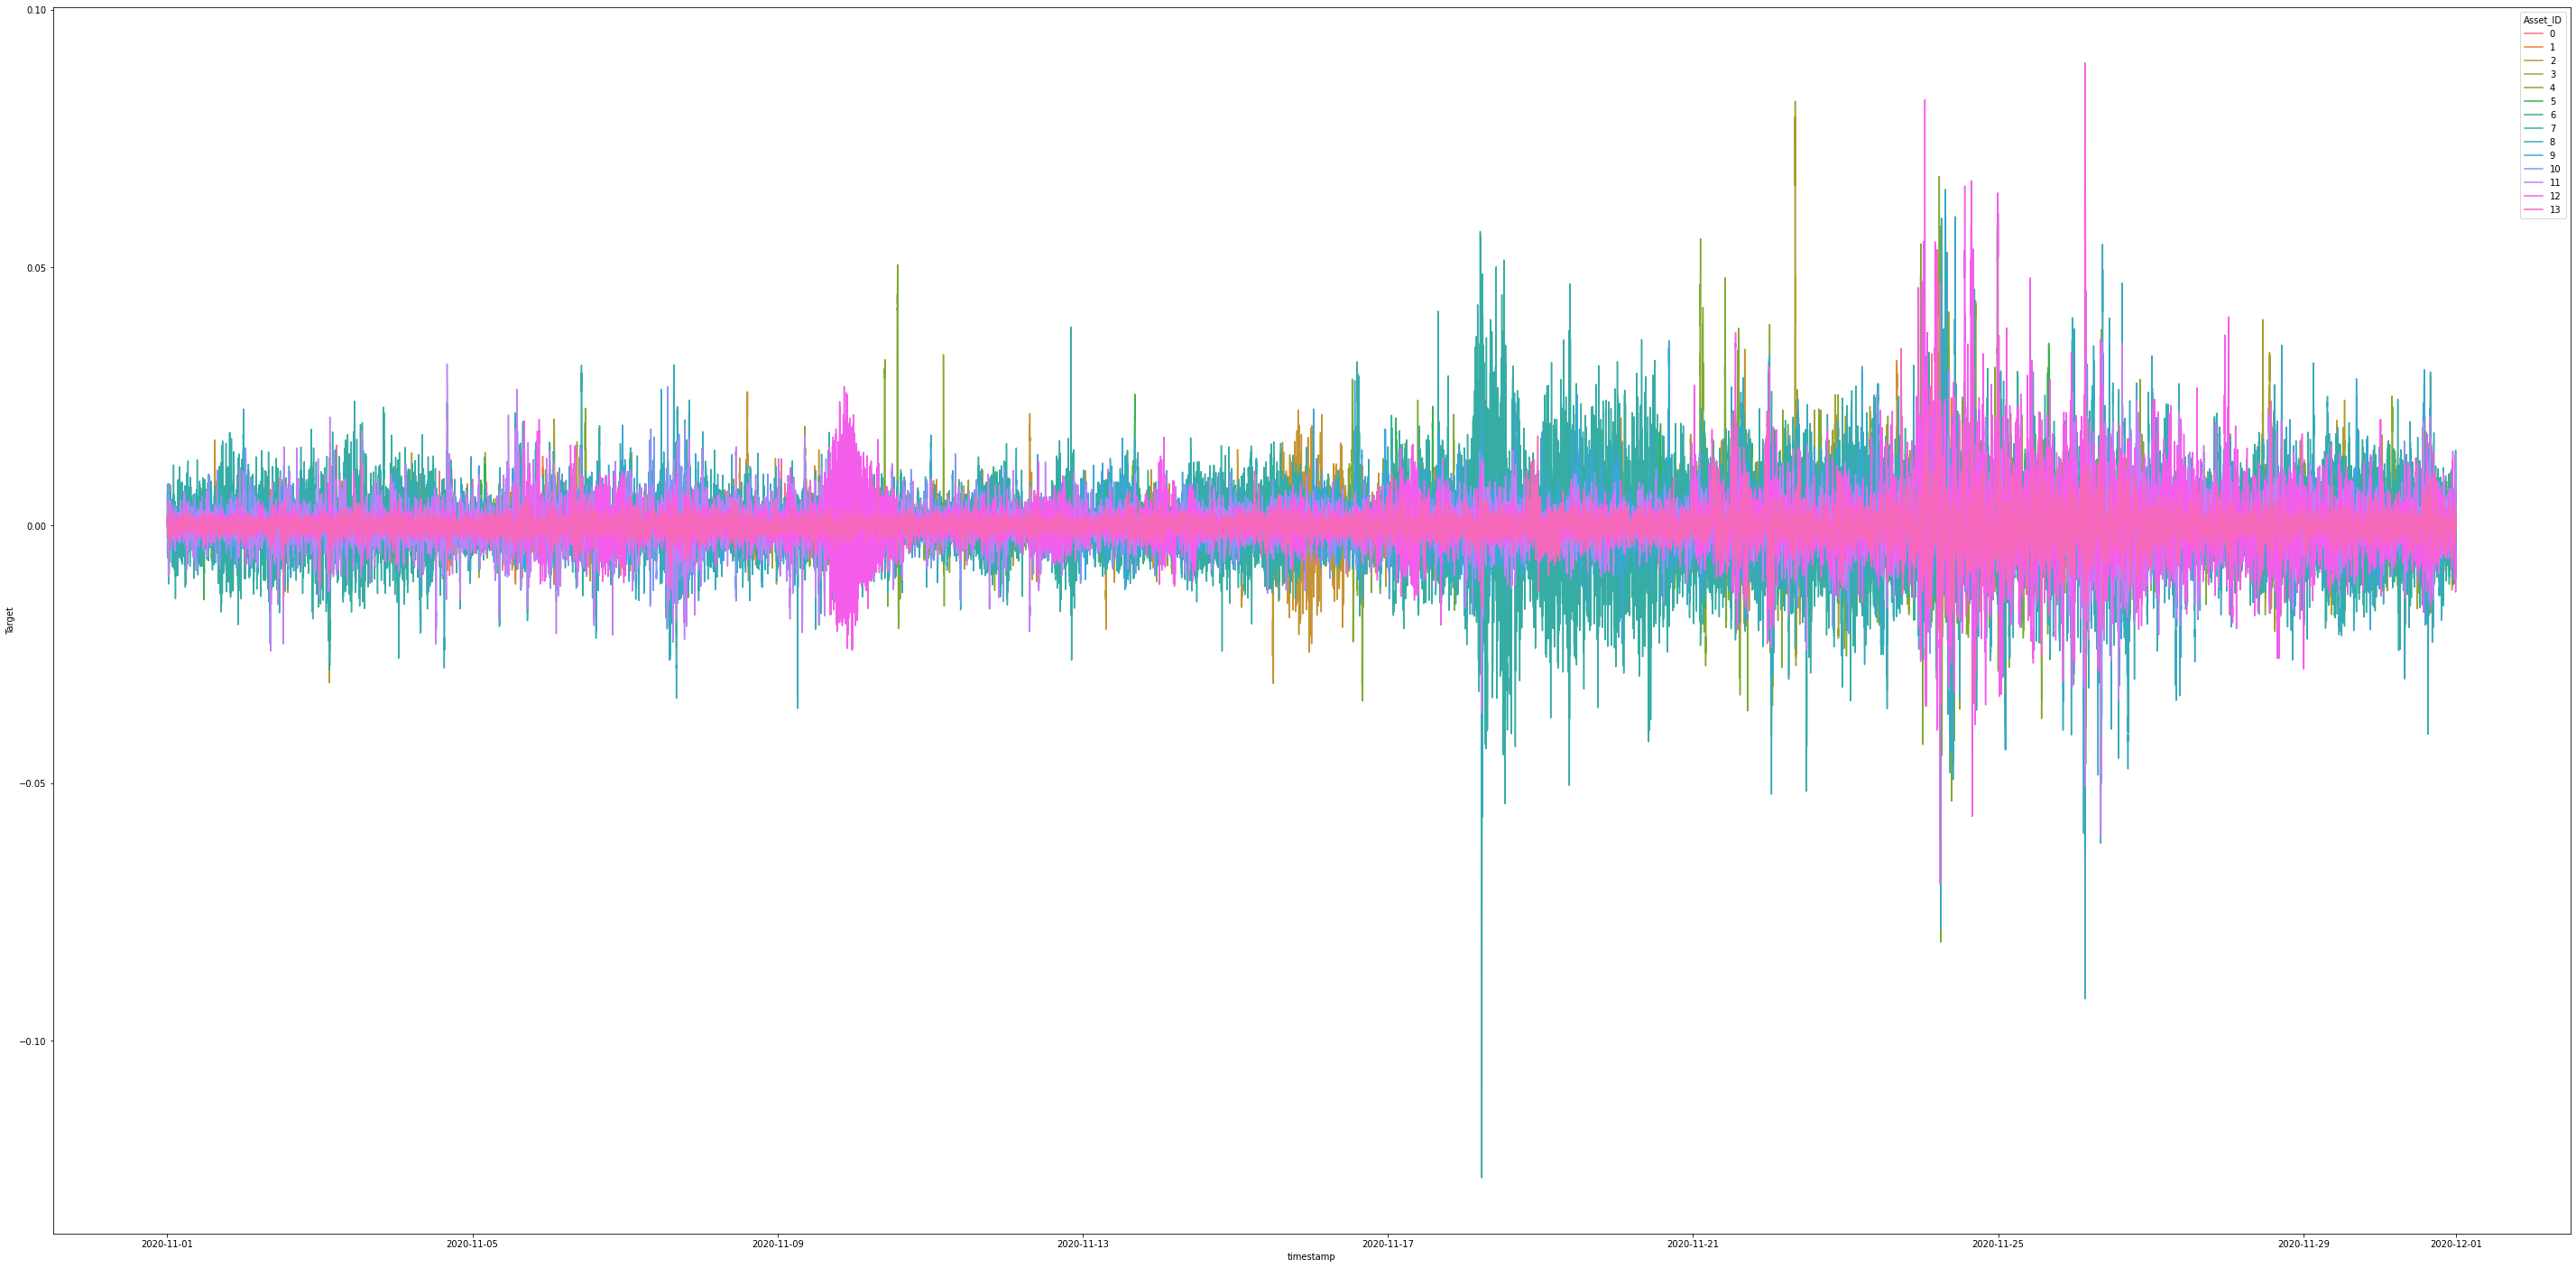

In [34]:
plt.figure(figsize=(50, 25))
sns.lineplot(data=df_train, x="timestamp", y="Target", hue="Asset_ID")

Target is 15 minutes residualized returns, which in theory is a return on an investment that is independent of the investment's benchmark. It is calculated as follows:

Residual return = Excess return - (Benchmark's excess return * beta).

The `Target` variable has very different patterns for each of the asset of interest.

#### Correlation Matrix
The following code provide correlation matrix for each of the asset.

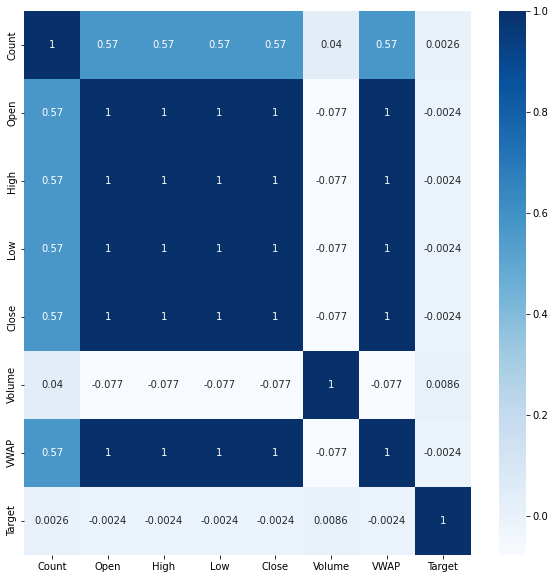

In [35]:
corr_matrix = df_train[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix,annot=True, cmap='Blues');

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.
The line of 1.00s going from the top left to the bottom right is the main diagonal, which shows that each variable always perfectly correlates with itself. 


The `Open`, `High`, `Low`, `Close`, and `VWAP` are highly correlated.

### Training and Testing Split
Use data from November 1st - November 26th as training set, use the rest data in November as validation set. The testing set is provided in `example_test.csv` file.

In [36]:
train_set = df_train[df_train.timestamp.dt.day <= 26]
val_set = df_train[df_train.timestamp.dt.day > 26]

In [37]:
train_set.shape

(510087, 57)

In [38]:
val_set.shape

(79868, 57)

In [39]:
train_set.Asset_ID.value_counts()

0     37439
1     37439
2     37439
3     37439
5     37439
6     37439
9     37439
10    37439
12    37439
13    37439
7     37385
11    36502
4     35232
8     26578
Name: Asset_ID, dtype: int64

In [40]:
val_set.Asset_ID.value_counts()

1     5760
2     5760
3     5760
5     5760
6     5760
7     5760
9     5760
10    5760
12    5760
13    5760
4     5731
11    5704
0     5689
8     5144
Name: Asset_ID, dtype: int64

Training set has 397522 observations and validation set has 201247 observations. And the number of observations for each asset is relatively balanced

In [45]:
input_cols = num_cols + encoded_cols
target_col = 'Target'
target_col

'Target'

### CREATING TEST DATASET

In [42]:
# Prepare test_df
df_test['timestamp'] = df_test.timestamp.astype('datetime64[s]')

# Create hour variable
df_test['hour'] = df_test.timestamp.dt.hour

# Create weekday variable
df_test['weekday'] = df_test.timestamp.dt.weekday

# Convert categorical variables
df_test['Asset_ID'] = df_test.Asset_ID.astype('category')
df_test['hour'] = df_test.hour.astype('category')
df_test['weekday'] = df_test.weekday.astype('category')

# one hot encoder categorical variables
encoder.fit(df_test[['Asset_ID','hour','weekday']])
encoded_cols = list(encoder.get_feature_names(['Asset_ID','hour','weekday']))
df_test[encoded_cols] = encoder.transform(df_test[['Asset_ID','hour','weekday']])

# scale numeric variables
scaler.fit(df_test[num_cols])
df_test[num_cols] = scaler.transform(df_test[num_cols])

df_test.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,...,Asset_ID_6,Asset_ID_7,Asset_ID_8,Asset_ID_9,Asset_ID_10,Asset_ID_11,Asset_ID_12,Asset_ID_13,hour_0,weekday_6
0,2021-06-13,3,0.333715,0.000040,0.000040,0.000040,0.000040,0.131450,0.000040,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2021-06-13,2,0.281956,0.016300,0.016375,0.016318,0.016353,0.000246,0.016345,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2021-06-13,0,0.169288,0.009656,0.009678,0.009669,0.009677,0.000345,0.009678,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,2021-06-13,1,0.816128,0.998807,1.000000,0.999136,1.000000,0.000033,0.999961,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,2021-06-13,4,0.114098,0.000007,0.000007,0.000007,0.000007,0.117553,0.000007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [43]:
df_test

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,...,Asset_ID_6,Asset_ID_7,Asset_ID_8,Asset_ID_9,Asset_ID_10,Asset_ID_11,Asset_ID_12,Asset_ID_13,hour_0,weekday_6
0,2021-06-13 00:00:00,3,0.333715,3.962561e-05,3.977222e-05,3.968485e-05,3.976596e-05,1.314496e-01,3.972151e-05,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2021-06-13 00:00:00,2,0.281956,1.630035e-02,1.637539e-02,1.631827e-02,1.635329e-02,2.462782e-04,1.634488e-02,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2021-06-13 00:00:00,0,0.169288,9.655992e-03,9.677889e-03,9.669015e-03,9.677284e-03,3.448143e-04,9.677554e-03,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,2021-06-13 00:00:00,1,0.816128,9.988066e-01,1.000000e+00,9.991357e-01,1.000000e+00,3.264657e-05,9.999609e-01,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,2021-06-13 00:00:00,4,0.114098,6.858843e-06,6.859146e-06,6.868316e-06,6.861211e-06,1.175534e-01,6.862382e-06,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,2021-06-13 00:00:00,5,0.092937,1.338477e-04,1.340119e-04,1.338190e-04,1.339716e-04,9.463747e-03,1.340081e-04,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,2021-06-13 00:00:00,7,0.144981,1.549443e-03,1.554620e-03,1.551055e-03,1.552633e-03,1.329759e-03,1.552092e-03,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,2021-06-13 00:00:00,6,0.615385,6.661084e-02,6.673133e-02,6.668678e-02,6.669055e-02,2.434959e-04,6.672140e-02,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,2021-06-13 00:00:00,8,0.000286,2.627028e-05,2.669512e-05,2.587527e-05,2.627284e-05,1.417431e-03,2.627466e-05,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9,2021-06-13 00:00:00,9,0.150415,4.547202e-03,4.555429e-03,4.549594e-03,4.554437e-03,2.978748e-04,4.557097e-03,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


# LINEAR REGRESSION

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
LReg = LinearRegression()
LReg

LinearRegression()

In [56]:
LReg.fit(train_set[input_cols], train_set[target_col])
print(train_set[target_col])
target_columns = pd.DataFrame(train_set[target_col])
target_columns.to_excel('Traintargets.xlsx')

17714600    0.001047
17714601   -0.002429
17714602   -0.005357
17714603    0.000794
17714604    0.004920
              ...   
18233038   -0.003378
18233039    0.002822
18233040   -0.002464
18233041   -0.000368
18233042   -0.009824
Name: Target, Length: 510087, dtype: float64


In [57]:
LReg_train_preds = LReg.predict(train_set[input_cols])
LReg_val_preds = LReg.predict(val_set[input_cols])

In [58]:

LReg_train_rmse = mean_squared_error(train_set[target_col], LReg_train_preds, squared=False)
LReg_val_rmse = mean_squared_error(val_set[target_col], LReg_val_preds, squared=False)

print("Train Error is ", LReg_train_rmse*100)
print("Validation Error is ", LReg_val_rmse*100)

Train Error is  0.451783700263171
Validation Error is  0.44539581833913283


#### Predicting on test set

In [59]:
LReg_test_pred = LReg.predict(df_test[input_cols])
LReg_test_pred

array([ 1.72698498e-03,  9.80019569e-04,  6.19053841e-04,  2.22218037e-03,
        1.06942654e-03,  4.19020653e-04,  6.07848167e-04,  2.06267834e-03,
        2.99334526e-04,  5.43355942e-04, -4.43458557e-05,  2.25925446e-03,
        1.10197067e-03,  1.81794167e-04,  9.71317291e-04,  1.20627880e-03,
        4.56333160e-04,  1.54924393e-03,  1.43802166e-03,  7.21335411e-04,
        5.97476959e-04,  1.17313862e-03,  3.87191772e-04,  3.69429588e-04,
       -5.09023666e-05,  3.69298458e-03,  9.51766968e-04,  1.23262405e-04,
        1.27518177e-03,  5.16057014e-04,  5.29766083e-04,  2.75051594e-03,
        4.12786007e-03,  4.35471535e-04,  8.86917114e-04,  1.74307823e-03,
        3.20196152e-04,  4.25577164e-04, -3.36170197e-05,  2.19643116e-03,
        1.12211704e-03,  1.09672546e-04,  1.33991241e-03,  3.91244888e-04,
        6.06775284e-04,  2.29883194e-03,  2.90644169e-03,  5.13672829e-04,
        4.17590141e-04,  2.48956680e-03,  4.65750694e-04,  4.17828560e-04,
       -5.88893890e-05,  

In [61]:
datal = pd.DataFrame(LReg_test_pred)
datal

,0
0,0.001727
1,0.000980
2,0.000619
3,0.002222
4,0.001069
5,0.000419
6,0.000608
7,0.002063
8,0.000299
9,0.000543


In [62]:
datal.to_excel('linearpredict.xlsx')

# Decision trees

#### Creating Base Decision tree model before hyperparam tuning

In [63]:
#Create an object (model)
DT = DecisionTreeRegressor(max_depth=2,
                             random_state=1)

DT.fit(train_set[input_cols], train_set[target_col])

DecisionTreeRegressor(max_depth=2, random_state=1)

In [64]:
DT_train_preds = DT.predict(train_set[input_cols])
DT_val_preds = DT.predict(val_set[input_cols])

In [65]:

DT_train_rmse = mean_squared_error(train_set[target_col], DT_train_preds, squared=False)
DT_val_rmse = mean_squared_error(val_set[target_col], DT_val_preds, squared=False)

print("Train Error is ", DT_train_rmse*100)
print("Validation Error is ", DT_val_rmse*100)

Train Error is  0.4515039993826516
Validation Error is  0.4459181240289247


#### Performing Grid Search to find best hyperparameters

In [66]:


DT_GS = DecisionTreeRegressor()

gs_DT = GridSearchCV(DT_GS,
                  param_grid = {'max_depth': range(1, 11),
                                'min_samples_split': range(10, 60, 10)},
                  cv=5,
                  n_jobs=1,
                  scoring='neg_root_mean_squared_error')

gs_DT.fit(train_set[input_cols], train_set[target_col])

print(gs_DT.best_params_)
print(-gs_DT.best_score_)


{'max_depth': 1, 'min_samples_split': 10}
0.00418323335733631


#### Creating  Decision tree model after hyperparam tuning

In [67]:
score_DT = DT.score(train_set[input_cols],DT_train_preds)
print("Score of Decision tree is ",score_DT)

Score of Decision tree is  1.0


In [69]:
score_LR = LReg.score(train_set[input_cols],LReg_train_preds)
print("Score of Linear Regression is ",score_LR)

Score of Linear Regression is  1.0


In [70]:
## change parameter vales in below code. 

In [71]:
#Create an object (model)
DT_2 = DecisionTreeRegressor(max_depth=1,
                             min_samples_split=10)

DT_2.fit(train_set[input_cols], train_set[target_col])

DecisionTreeRegressor(max_depth=1, min_samples_split=10)

In [72]:
DT_2_train_preds = DT_2.predict(train_set[input_cols])
DT_2_val_preds = DT_2.predict(val_set[input_cols])

In [73]:

DT_2_train_rmse = mean_squared_error(train_set[target_col], DT_2_train_preds, squared=False)
DT_2_val_rmse = mean_squared_error(val_set[target_col], DT_2_val_preds, squared=False)

print("Train Error is ", DT_2_train_rmse*100)
print("Validation Error is ", DT_2_val_rmse*100)

Train Error is  0.45186397002173306
Validation Error is  0.4454573828646935


In [74]:
DT_2_test_pred = DT_2.predict(df_test[input_cols])
DT_2_test_pred

array([ 4.00368884e-04, -6.58513750e-06, -6.58513750e-06, -6.58513750e-06,
        4.00368884e-04,  4.00368884e-04, -6.58513750e-06, -6.58513750e-06,
       -6.58513750e-06, -6.58513750e-06, -6.58513750e-06,  4.00368884e-04,
        4.00368884e-04, -6.58513750e-06,  4.00368884e-04, -6.58513750e-06,
       -6.58513750e-06, -6.58513750e-06,  4.00368884e-04,  4.00368884e-04,
       -6.58513750e-06, -6.58513750e-06,  4.00368884e-04, -6.58513750e-06,
       -6.58513750e-06,  4.00368884e-04,  4.00368884e-04, -6.58513750e-06,
        4.00368884e-04, -6.58513750e-06, -6.58513750e-06, -6.58513750e-06,
        4.00368884e-04,  4.00368884e-04, -6.58513750e-06, -6.58513750e-06,
       -6.58513750e-06, -6.58513750e-06, -6.58513750e-06,  4.00368884e-04,
        4.00368884e-04, -6.58513750e-06,  4.00368884e-04, -6.58513750e-06,
       -6.58513750e-06, -6.58513750e-06,  4.00368884e-04, -6.58513750e-06,
       -6.58513750e-06, -6.58513750e-06,  4.00368884e-04, -6.58513750e-06,
       -6.58513750e-06,  

In [75]:
datad = pd.DataFrame(DT_2_test_pred)
datad.to_excel('dtpredict.xlsx')

In [76]:
score_DT2 = DT_2.score(train_set[input_cols],DT_2_train_preds)
print("Score of Decision tree after hypertuning is ",score_DT2)

Score of Decision tree after hypertuning is  1.0


In [77]:
DT_test_pred = DT.predict(df_test[input_cols])
DT_test_pred

array([ 1.65052438e-04, -5.47667862e-05, -5.47667862e-05, -5.47667862e-05,
        1.65052438e-04,  1.65052438e-04, -5.47667862e-05, -5.47667862e-05,
        6.03858371e-05, -5.47667862e-05, -5.47667862e-05,  1.65052438e-04,
        2.12024368e-03, -5.47667862e-05,  1.65052438e-04, -5.47667862e-05,
       -5.47667862e-05, -5.47667862e-05,  1.65052438e-04,  1.65052438e-04,
       -5.47667862e-05, -5.47667862e-05,  1.65052438e-04, -5.47667862e-05,
       -5.47667862e-05,  1.65052438e-04,  2.12024368e-03, -5.47667862e-05,
        1.65052438e-04, -5.47667862e-05, -5.47667862e-05, -5.47667862e-05,
        1.65052438e-04,  1.65052438e-04, -5.47667862e-05, -5.47667862e-05,
        6.03858371e-05, -5.47667862e-05, -5.47667862e-05,  1.65052438e-04,
        2.12024368e-03, -5.47667862e-05,  1.65052438e-04, -5.47667862e-05,
       -5.47667862e-05, -5.47667862e-05,  1.65052438e-04,  6.03858371e-05,
       -5.47667862e-05, -5.47667862e-05,  1.65052438e-04, -5.47667862e-05,
       -5.47667862e-05,  

In [78]:
datad2 = pd.DataFrame(DT_test_pred)
datad2.to_excel('dtpredict2.xlsx')

## Random Forest
This section builds random forest to predict the `Target` variable.

#### Creating Base Random Forest model before hyperparam tuning

In [79]:
# Create the model
RF_1 = RandomForestRegressor(random_state=5, n_jobs = -1)

In [80]:
RF_1.fit(train_set[input_cols], train_set[target_col])


RandomForestRegressor(n_jobs=-1, random_state=5)

In [81]:
# Model Evaluation
RF_1_train_preds = RF_1.predict(train_set[input_cols])
RF_1_val_preds = RF_1.predict(val_set[input_cols])

RF_1_train_rmse = mean_squared_error(train_set[target_col], RF_1_train_preds, squared=False)
RF_1_val_rmse = mean_squared_error(val_set[target_col], RF_1_val_preds, squared=False)



In [82]:
print("Train Error is ", RF_1_train_rmse*100)
print("Validation Error is ", RF_1_val_rmse*100)

Train Error is  0.17661320912133166
Validation Error is  0.5149876623908646


In [83]:
RF_test_pred_1 = RF_1.predict(df_test[input_cols])
RF_test_pred_1

array([ 3.69138079e-03,  1.47314305e-03, -6.54766069e-04, -3.85016125e-03,
       -1.36936980e-02,  1.37188419e-03, -6.79470917e-05,  1.12319493e-03,
       -1.59798048e-02, -2.60324493e-03,  3.64173055e-05, -4.72572355e-03,
        1.07934108e-02, -4.38757031e-04, -1.36050388e-03,  1.67705771e-03,
       -1.06069043e-03, -4.00348373e-03, -1.45263918e-02, -7.07324882e-04,
        1.07436189e-04, -3.71213572e-04, -1.07803966e-02, -3.78720391e-03,
        1.57123640e-05, -9.93826395e-03,  1.01743040e-02, -5.34378325e-04,
        3.10288340e-03,  1.02272157e-03, -1.81709449e-04, -3.85016125e-03,
       -1.33267975e-02,  4.20672952e-04, -2.45888315e-04,  4.99537882e-05,
       -1.75200072e-02, -3.63116681e-03, -1.44468378e-05, -8.71974053e-03,
        1.24975715e-02, -9.15616898e-04, -1.15008744e-03,  8.64503298e-04,
        9.37335261e-05, -3.85016125e-03, -1.32922223e-02, -3.96977666e-03,
       -2.61907857e-04,  2.93921667e-03, -2.58081038e-03, -3.64588517e-03,
        1.26228259e-05, -

In [84]:
datarf1 = pd.DataFrame(RF_test_pred_1)
datarf1.to_excel('rfpredict1.xlsx')

#### Hyper parameter tuning Random forest

In [85]:
def test_param(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        RF_hyp = RandomForestRegressor(random_state=5, n_jobs=-1, **params).fit(train_set[input_cols], train_set[target_col])
        train_rmse = mean_squared_error(RF_hyp.predict(train_set[input_cols]), train_set[target_col], squared=False)
        val_rmse = mean_squared_error(RF_hyp.predict(val_set[input_cols]), val_set[target_col], squared=False)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

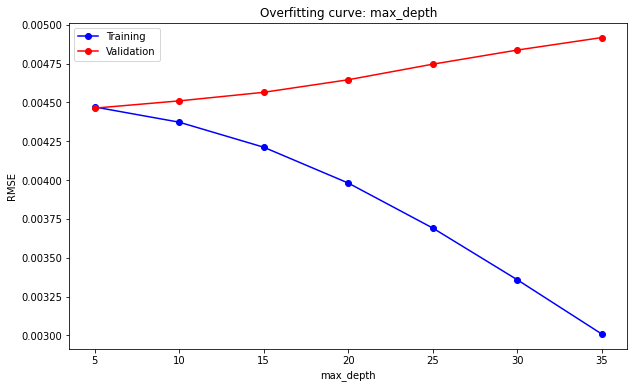

In [86]:
test_param('max_depth', [5, 10, 15, 20, 25, 30, 35])

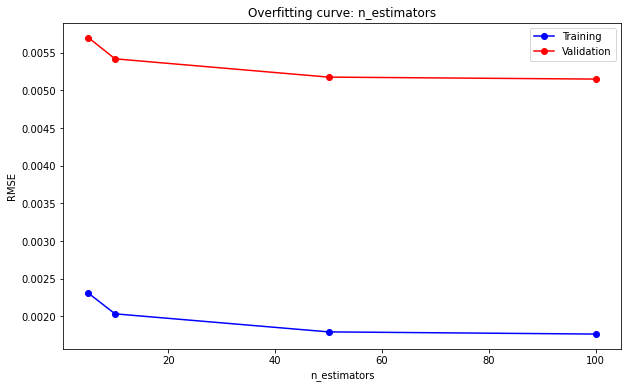

In [87]:
test_param('n_estimators', [5, 10, 50, 100])

#### Creating  Random Forest model after hyperparam tuning

In [88]:
## change parameter vales in below code. 

In [89]:
RF_2 = RandomForestRegressor(random_state=5, n_jobs = -1, max_depth=5, n_estimators=10)

RF_2.fit(train_set[input_cols], train_set[target_col])

RF_2_train_preds = RF_2.predict(train_set[input_cols])
RF_2_val_preds = RF_2.predict(val_set[input_cols])

RF_2_train_rmse = mean_squared_error(train_set[target_col], RF_2_train_preds, squared=False)
RF_2_val_rmse = mean_squared_error(val_set[target_col], RF_2_val_preds, squared=False)



In [90]:
print("Train Error is ", RF_2_train_rmse*100)
print("Validation Error is ", RF_2_val_rmse*100)

Train Error is  0.44789578904883265
Validation Error is  0.44676362611068754


#### Predicting on test set

In [91]:
# testing on test set
RF_test_pred = RF_2.predict(df_test[input_cols])
RF_test_pred

array([ 1.43213231e-03,  1.14403492e-04,  1.14403492e-04, -2.61594340e-03,
       -8.01331558e-03,  6.10954945e-04,  2.97540735e-04,  8.86425230e-04,
       -7.96950799e-03,  1.14403492e-04, -4.35819533e-05, -6.91640533e-03,
        1.39863852e-02, -4.35819533e-05,  1.74875567e-03,  1.14403492e-04,
        1.14403492e-04, -2.61594340e-03, -9.41233351e-03,  6.10954945e-04,
        2.97540735e-04, -4.35819533e-05, -3.93513143e-04,  1.14403492e-04,
       -4.35819533e-05, -1.08453127e-02,  1.09181710e-02, -4.35819533e-05,
        1.74875567e-03, -4.35819533e-05,  1.14403492e-04, -2.61594340e-03,
       -1.25134563e-02,  1.61036078e-04,  3.11632954e-04,  7.25355661e-05,
       -9.97875561e-03,  1.14403492e-04, -4.35819533e-05, -9.14776187e-03,
        1.49220455e-02, -4.35819533e-05,  1.74875567e-03, -4.35819533e-05,
        1.14403492e-04, -2.61594340e-03, -1.25134563e-02,  9.05475504e-05,
        2.97540735e-04,  1.06956247e-03, -4.51127537e-04,  1.14403492e-04,
       -4.35819533e-05, -

In [92]:
datarf2 = pd.DataFrame(RF_test_pred)
datarf2.to_excel('rfpredict2.xlsx')

# GRADIENT BOOSTING 

#### Creating Base Gradient Boosting model before hyperparam tuning

In [93]:
# Create the model
GB = XGBRegressor(random_state=5, n_jobs=-1, n_estimators=20, max_depth=4)

In [94]:
# Fit the model
GB.fit(train_set[input_cols], train_set[target_col])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=5, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [95]:
# Model Evaluation
GB_train_preds = GB.predict(train_set[input_cols])
GB_val_preds = GB.predict(val_set[input_cols])

GB_train_rmse = mean_squared_error(train_set[target_col], GB_train_preds, squared=False)
GB_val_rmse = mean_squared_error(val_set[target_col], GB_val_preds, squared=False)

print("Train Error is ", GB_train_rmse*100)
print("Validation Error is ", GB_val_rmse*100)

Train Error is  0.44680318797667656
Validation Error is  0.44789917307590627


In [98]:
gb1 = GB.predict(df_test[input_cols])
gb1

array([-0.01488691,  0.00030482,  0.00030482, -0.00185613, -0.00440601,
        0.00059442,  0.00104839,  0.00111374, -0.00619087,  0.00030482,
       -0.00041379, -0.00182263,  0.00994834,  0.00030482, -0.01257887,
        0.00058051,  0.00030482, -0.00185613, -0.011485  ,  0.00059442,
        0.00104839,  0.00111374, -0.00561695,  0.00030482, -0.0003984 ,
       -0.00694404,  0.00600121,  0.00030482, -0.01257887,  0.00030482,
        0.00030482, -0.00185613, -0.01281839,  0.00059442,  0.00104839,
        0.00111374, -0.00569904,  0.00030482, -0.00041379, -0.00296628,
        0.00328643,  0.00030482, -0.01257887,  0.00030482,  0.00030482,
       -0.00185613, -0.01281839,  0.00051233,  0.00104839,  0.00111374,
       -0.00544576,  0.00030482, -0.00164593, -0.00146985,  0.01114144,
        0.00030482], dtype=float32)

In [99]:
datagb1 = pd.DataFrame(gb1)
datagb1.to_excel('gbpredict1.xlsx')

#### Hyper parameter tuning Gradient Boosting

In [100]:
def test_param_GB(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        GB_Hyp = XGBRegressor(random_state=5, n_jobs=-1, **params).fit(train_set[input_cols], train_set[target_col])
        train_rmse = mean_squared_error(GB_Hyp.predict(train_set[input_cols]), train_set[target_col], squared=False)
        val_rmse = mean_squared_error(GB_Hyp.predict(val_set[input_cols]), val_set[target_col], squared=False)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

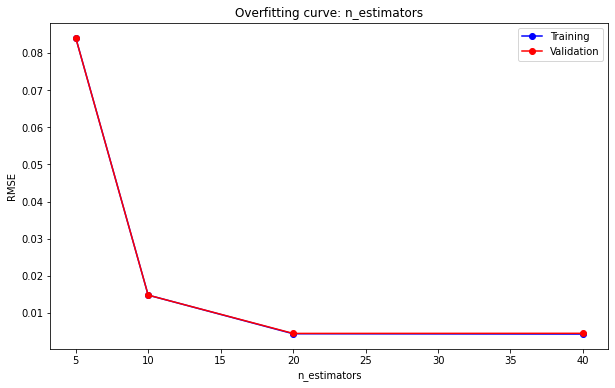

In [101]:
# n_estimators
test_param_GB('n_estimators', [5, 10, 20, 40])

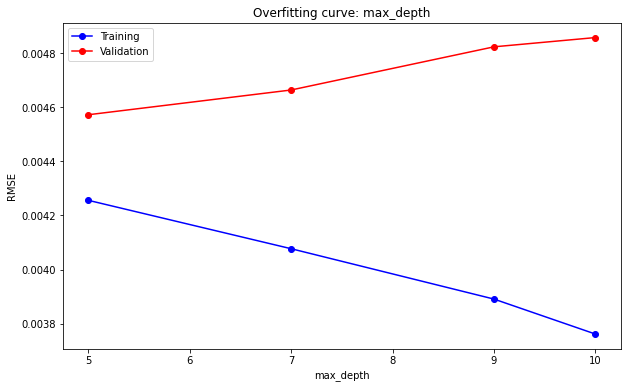

In [102]:
# max_depth
test_param_GB('max_depth', [5, 7, 9, 10])

#### Creating  Gradient boosting model after hyperparam tuning

In [103]:
## change parameter vales in below code. 

In [104]:
# tuned model
GB2 = XGBRegressor(random_state=5, n_jobs=-1, n_estimators=20, max_depth=5)

GB2.fit(train_set[input_cols], train_set[target_col])

GB2_train_preds = GB2.predict(train_set[input_cols])
GB2_val_preds = GB2.predict(val_set[input_cols])

GB2_train_rmse = mean_squared_error(train_set[target_col], GB2_train_preds, squared=False)
GB2_val_rmse = mean_squared_error(val_set[target_col], GB2_val_preds, squared=False)

print("Train Error is ", GB2_train_rmse)
print("Validation Error is ", GB2_val_rmse)

Train Error is  0.004440500381157483
Validation Error is  0.004506764884103312


#### Predicting on test set

In [105]:
GB_test_pred = GB2.predict(df_test[input_cols])
GB_test_pred

array([-5.5150711e-03,  1.4318363e-03,  4.9082458e-04, -3.1085708e-03,
       -2.0081778e-03, -4.4339526e-05,  1.6748027e-03,  2.1869994e-03,
       -3.5520587e-03,  4.9082458e-04,  1.2801158e-04,  2.2540614e-03,
        5.8158892e-03,  4.9082458e-04, -6.7346394e-03,  1.4318363e-03,
        4.9082458e-04, -3.1085708e-03, -2.4194936e-03, -4.7720647e-03,
        1.6748027e-03,  9.8198198e-04, -3.2327669e-03,  4.9082458e-04,
        1.2801158e-04,  8.5055269e-04, -2.1810427e-03,  4.9082458e-04,
       -6.2949904e-03,  4.9082458e-04,  4.9082458e-04, -3.1085708e-03,
       -2.8985438e-03, -4.4339526e-05,  2.1144520e-03,  2.1869994e-03,
       -3.5520587e-03,  4.9082458e-04,  1.2801158e-04,  5.0310702e-03,
        6.9483058e-03,  4.9082458e-04, -6.2949904e-03,  4.9082458e-04,
        4.9082458e-04, -3.1085708e-03, -2.8985438e-03,  6.1892241e-04,
        1.4746429e-03,  3.1708188e-03, -5.6409766e-03,  4.9082458e-04,
       -1.3255371e-03,  8.6393184e-04,  7.0809294e-03,  4.9082458e-04],
     

In [106]:
datagb2 = pd.DataFrame(GB_test_pred)
datagb2.to_excel('gbpredict2.xlsx')

## FINAL RESULTS

In [107]:
print("Train Error of Linear Regression is ", LReg_train_rmse*100)
print("Validation Error of Linear Regression is ", LReg_val_rmse*100)
print("\n--------------------------------------------\n")

print("Train Error Decision Trees before hyperparam tune is", DT_train_rmse*100)
print("Validation Error Decision Trees before hyperparam tune is ", DT_val_rmse*100)
print("\n")
print("Train Error Decision Trees after hyperparam tune is", DT_2_train_rmse*100)
print("Validation Error Decision Trees after hyperparam tune is ", DT_2_val_rmse*100)
print("\n--------------------------------------------\n")


print("Train Error Random Forest before hyperparam tune is ", RF_1_train_rmse*100)
print("Validation Error Random Forest before hyperparam tune is ", RF_1_val_rmse*100)
print("\n")
print("Train Error Random Forest after hyperparam tune is ", RF_2_train_rmse*100)
print("Validation Error Random Forest after hyperparam tune is ", RF_2_val_rmse*100)
print("\n--------------------------------------------\n")

print("Train Error XGboost before hyperparam tune is", GB_train_rmse*100)
print("Validation Error XGboost before hyperparam tune is ", GB_val_rmse*100)
print("\n")
print("Train Error XGboost after hyperparam tune is ", GB2_train_rmse *100)
print("Validation Error XGboost after hyperparam tune is ", GB2_val_rmse*100)

Train Error of Linear Regression is  0.451783700263171
Validation Error of Linear Regression is  0.44539581833913283

--------------------------------------------

Train Error Decision Trees before hyperparam tune is 0.4515039993826516
Validation Error Decision Trees before hyperparam tune is  0.4459181240289247


Train Error Decision Trees after hyperparam tune is 0.45186397002173306
Validation Error Decision Trees after hyperparam tune is  0.4454573828646935

--------------------------------------------

Train Error Random Forest before hyperparam tune is  0.17661320912133166
Validation Error Random Forest before hyperparam tune is  0.5149876623908646


Train Error Random Forest after hyperparam tune is  0.44789578904883265
Validation Error Random Forest after hyperparam tune is  0.44676362611068754

--------------------------------------------

Train Error XGboost before hyperparam tune is 0.44680318797667656
Validation Error XGboost before hyperparam tune is  0.44789917307590627


